# Dutch primary school CET score
 
## Overview

In The Netherlands children start going to school when they turn 4. So now I need to choose the best school for my toddler. I think it should meet a large number of charactheristic. It should be able to give my child a worthy knowlegde, so that he gets a good score in the final exam to continue his education in a good secondary school.

I found that Dutch Ministry of education, culture and science has opened some of their data. I collected the data from https://duo.nl/open_onderwijsdata/databestanden/ into a dataset and now I want to analyse what I have there. Ideally I would also want to find if it is possible to calcuate the quality of the education which school can give to students based on the data we have or if we need some extra data to define this.

One of the main factors that could define a quality of education is the final exams score. I will analyse it first.

First of all I want to know what does CET score depend on and how it is defined by other factors. To solve this problem I'm going to read the dataset from the file Score.csv and get data from the latest year we have(2018). I will clean it, will make a new feature which would mean the level of the average CET score for each school.

As a result I will try to build a classifier for those CET score levels to be able to predict how "good" the exam result will be depending on other parameters we have. To do that I will use a number of classification algorithms and pick the best one.

## Data preparation

Let's start with reading the dataset from the file 'Score.csv'. We'll read data for only one year (for example, the year of 2018):

In [66]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data_score = pd.read_csv("./make_school_data/main/output/Score.csv", error_bad_lines=False, sep=',', encoding = "ISO-8859-1") 
data_score = data_score[data_score['DATUM'] == 2018]
print(data_score.shape)
print(data_score.columns)
data_score.head()

(6286, 33)
Index(['SCHOOL_ID', 'DATUM', 'INSTELLINGSNAAM_VESTIGING', 'POSTCODE_VESTIGING',
       'PLAATSNAAM', 'GEMEENTENAAM', 'PROVINCIE', 'SOORT_PO',
       'DENOMINATIE_VESTIGING', 'EXAMEN', 'EXAMEN_AANTAL', 'EXAMEN_GEM',
       'REKENEN_LAGER1F', 'REKENEN_1F', 'REKENEN_1S', 'REKENEN_2F',
       'LV_LAGER1F', 'LV_1F', 'LV_2F', 'TV_LAGER1F', 'TV_1F', 'TV_2F', 'VSO',
       'PRO', 'VMBO', 'VMBO_HAVO', 'HAVO', 'HAVO_VWO', 'VWO',
       'ADVIES_NIET_MOGELIJK', 'TOTAAL_ADVIES', 'LJ8', 'ZIT'],
      dtype='object')


,SCHOOL_ID,DATUM,INSTELLINGSNAAM_VESTIGING,POSTCODE_VESTIGING,PLAATSNAAM,GEMEENTENAAM,PROVINCIE,SOORT_PO,DENOMINATIE_VESTIGING,EXAMEN,...,PRO,VMBO,VMBO_HAVO,HAVO,HAVO_VWO,VWO,ADVIES_NIET_MOGELIJK,TOTAAL_ADVIES,LJ8,ZIT
18739,000AP_2018,2018,De Schanskorf,2715BT,ZOETERMEER,Zoetermeer,Zuid-Holland,Bo,Gereformeerd vrijgemaakt,CET,...,0,0,2,4,0,3,0,11,11,1
18740,000AR_2018,2018,"BS ""De Maasparel""",6107AW,STEVENSWEERT,Maasgouw,Limburg,Bo,Rooms-Katholiek,CET,...,0,1,0,4,0,9,0,17,17,1
18741,000AV_2018,2018,De Morgenster,3201CN,SPIJKENISSE,Nissewaard,Zuid-Holland,Bo,Gereformeerd vrijgemaakt,CET,...,0,0,3,1,3,2,0,12,12,1
18742,000AZ_2018,2018,De Stapsteen,2971AR,BLESKENSGRAAF CA,Molenwaard,Zuid-Holland,Bo,Openbaar,IEP,...,2,1,5,3,0,3,0,15,14,2
18743,000BB_2018,2018,Obs Letterwies,9944AR,NIEUWOLDA,Oldambt,Groningen,Bo,Openbaar,CET,...,0,5,2,4,1,2,0,21,11,1


I want to create a new variable which would mean how well students of a particular school take the exam. We have a few exams chosen by schools, let's take a look at them:

In [67]:
data_score['EXAMEN'].value_counts()

CET       3527
IEP       1790
ROUTE8     833
DIA         83
AMN         53
Name: EXAMEN, dtype: int64

I will create a new variable called **SCORE_TYPE** with values 'low' and 'high' depending on the score and on the chosen exam, because the average score is different for different exams:

In [68]:
def get_type_score(row): 
    result = "Low"
    exam_data = data_score[data_score['EXAMEN'] == row.EXAMEN]
    if(row.EXAMEN_GEM < exam_data['EXAMEN_GEM'].median()):
        result = "Low"
    else:
        result = "High"
    return result

data_score['SCORE_LEVEL'] =  data_score.apply(lambda row: get_type_score(row), axis = 1)

In [69]:
print(data_score['SCORE_LEVEL'].value_counts())

High    3146
Low     3140
Name: SCORE_LEVEL, dtype: int64


Next I want to remove unnecessary columns because some of them are higly correlated (like a few columns which describe an address of a school, we can leave only one of them) and some of them – we just don't need (like **SCHOOL_ID** or **BEVOEGD_GEZAG_NUMMER**), or they mean the same thing as outcome (like the score variable **EXAMEN_GEM**):

In [70]:
columns = ['EXAMEN_GEM', 'SCHOOL_ID', 'DATUM', 'INSTELLINGSNAAM_VESTIGING', 'POSTCODE_VESTIGING', 
           'PLAATSNAAM', 'GEMEENTENAAM', 'PROVINCIE']
print(data_score.shape)
data = data_score.drop(columns, 1)
print(data.shape)
print(data.columns)
data.head()

(6286, 34)
(6286, 26)
Index(['SOORT_PO', 'DENOMINATIE_VESTIGING', 'EXAMEN', 'EXAMEN_AANTAL',
       'REKENEN_LAGER1F', 'REKENEN_1F', 'REKENEN_1S', 'REKENEN_2F',
       'LV_LAGER1F', 'LV_1F', 'LV_2F', 'TV_LAGER1F', 'TV_1F', 'TV_2F', 'VSO',
       'PRO', 'VMBO', 'VMBO_HAVO', 'HAVO', 'HAVO_VWO', 'VWO',
       'ADVIES_NIET_MOGELIJK', 'TOTAAL_ADVIES', 'LJ8', 'ZIT', 'SCORE_LEVEL'],
      dtype='object')


,SOORT_PO,DENOMINATIE_VESTIGING,EXAMEN,EXAMEN_AANTAL,REKENEN_LAGER1F,REKENEN_1F,REKENEN_1S,REKENEN_2F,LV_LAGER1F,LV_1F,...,VMBO,VMBO_HAVO,HAVO,HAVO_VWO,VWO,ADVIES_NIET_MOGELIJK,TOTAAL_ADVIES,LJ8,ZIT,SCORE_LEVEL
18739,Bo,Gereformeerd vrijgemaakt,CET,11,1,5,5,0,0,1,...,0,2,4,0,3,0,11,11,1,High
18740,Bo,Rooms-Katholiek,CET,17,0,5,12,0,1,1,...,1,0,4,0,9,0,17,17,1,High
18741,Bo,Gereformeerd vrijgemaakt,CET,11,1,5,5,0,0,6,...,0,3,1,3,2,0,12,12,1,Low
18742,Bo,Openbaar,IEP,12,2,3,7,0,0,2,...,1,5,3,0,3,0,15,14,2,High
18743,Bo,Openbaar,CET,21,1,14,6,0,0,4,...,5,2,4,1,2,0,21,11,1,Low


Let's take a look at the outcome:

High    3146
Low     3140
Name: SCORE_LEVEL, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


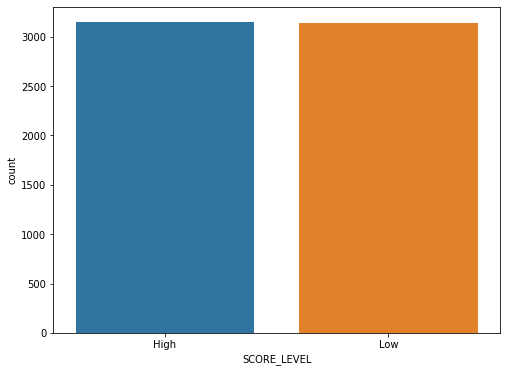

In [71]:
print(data['SCORE_LEVEL'].value_counts())
plt.figure(figsize=(8,6))
print(sns.countplot(x='SCORE_LEVEL',data=data, 
                    order = data['SCORE_LEVEL'].value_counts().index))

The outcome (the **SCORE_LEVEL** column) has almost the same amount of values for both results `High` and `Low`, so we don't need to do anything with this sample (like oversampling or undersampling) and can just continue with the analysis.

Let's encode categorical variables using LabelEncoder:

In [72]:
from sklearn.preprocessing import LabelEncoder

data['SOORT_PO'] = LabelEncoder().fit_transform(data['SOORT_PO'])

data['DENOMINATIE_VESTIGING'] = LabelEncoder().fit_transform(data['DENOMINATIE_VESTIGING'])

data['EXAMEN'] = LabelEncoder().fit_transform(data['EXAMEN'])

data['SCORE_LEVEL'] = LabelEncoder().fit_transform(data['SCORE_LEVEL'])
data.head()

,SOORT_PO,DENOMINATIE_VESTIGING,EXAMEN,EXAMEN_AANTAL,REKENEN_LAGER1F,REKENEN_1F,REKENEN_1S,REKENEN_2F,LV_LAGER1F,LV_1F,...,VMBO,VMBO_HAVO,HAVO,HAVO_VWO,VWO,ADVIES_NIET_MOGELIJK,TOTAAL_ADVIES,LJ8,ZIT,SCORE_LEVEL
18739,0,4,1,11,1,5,5,0,0,1,...,0,2,4,0,3,0,11,11,1,0
18740,0,12,1,17,0,5,12,0,1,1,...,1,0,4,0,9,0,17,17,1,0
18741,0,4,1,11,1,5,5,0,0,6,...,0,3,1,3,2,0,12,12,1,1
18742,0,9,3,12,2,3,7,0,0,2,...,1,5,3,0,3,0,15,14,2,0
18743,0,9,1,21,1,14,6,0,0,4,...,5,2,4,1,2,0,21,11,1,1


Before we can start modelling we need to normalize the data (using MinMaxScaler) and split it into train and test datasets:

In [73]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import  plot_roc_curve

random_state = 4004

def split_data(data): 
    
    X_train, X_test, y_train, y_test = train_test_split(data, pred, train_size=0.7, test_size=0.3, random_state=random_state)
    return X_train, X_test, y_train, y_test

pred = data['SCORE_LEVEL']
data.drop('SCORE_LEVEL', 1, inplace = True)
    
X_train, X_test, y_train, y_test = split_data(data)

## Building models

Let' start modelling. I will build a classification model using several ML algorithms: Random forest, K Nearest Neighbors, Support Vector Machine and XGBoost. 

### Random forest

In [74]:
def random_forest(X_train, X_test, y_train, y_test):
    rfc = RandomForestClassifier(n_estimators=100, random_state = random_state)
    rfc.fit(X_train, y_train)
    pred_test = rfc.predict(X_test)
 
    rfc_score = 100 * rfc.score(X_test, y_test)
    print("Score is: %3.2f" % (rfc_score))
    
    rfc_disp = plot_roc_curve(rfc, X_test, y_test)
    return rfc, rfc_score, rfc_disp

Random Forest
Score is: 89.29


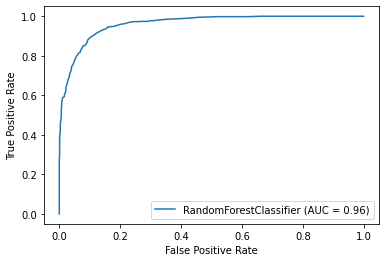

In [75]:
print("Random Forest")
rfc, rfc_score, rfc_disp = random_forest(X_train, X_test, y_train, y_test)

### K Nearest Neighbors 

In [76]:
def knn(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    pred_test = knn.predict(X_test)
    knn_score = 100 * knn.score(X_test, y_test)
    print("Score is: %3.2f" % (knn_score))
    knn_disp = plot_roc_curve(knn, X_test, y_test)
    return knn, knn_score, knn_disp

KNN
Score is: 83.99


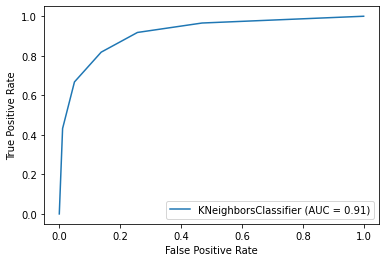

In [77]:
print("KNN")
knn, knn_score, knn_disp = knn(X_train, X_test, y_train, y_test)

### Support Vector Machine

In [78]:
def svc(X_train, X_test, y_train, y_test):
    svc = SVC()
    svc.fit(X_train, y_train)
    pred_test = svc.predict(X_test)
    svc_score = 100 * svc.score(X_test, y_test)
    print("Score is: %3.2f" % (svc_score))
    svc_disp = plot_roc_curve(svc, X_test, y_test)
    return svc, svc_score, svc_disp

Support Vector Machine
Score is: 89.34


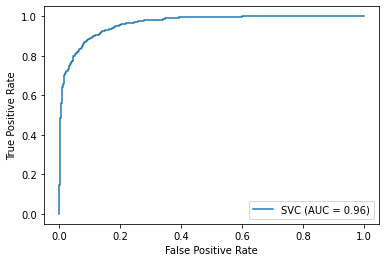

In [79]:
print("Support Vector Machine")
svc, svc_score, svc_disp = svc(X_train, X_test, y_train, y_test)

### XGBoost

In [80]:
def XGBoost(X_train, X_test, y_train, y_test):
    xgb = XGBClassifier(n_estimators=100)
    xgb.fit(X_train, y_train)
    pred_test = xgb.predict(X_test)
    xgb_score = (pred_test == y_test).sum() / len(pred_test)*100
    print("Score is: %3.2f" % (xgb_score))
    xgb_disp = plot_roc_curve(xgb, X_test, y_test)
    return xgb, xgb_score, xgb_disp

XGBoost
Score is: 89.40


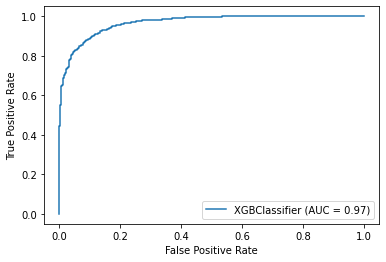

In [81]:
print("XGBoost")
xgb, xgb_score, xgb_disp = XGBoost(X_train, X_test, y_train, y_test)

## Results

We made a few models, let's check which one gave us the most accurate results:

In [82]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'KNN', 'SVC', 'XGBoost'],
    'Score': [rfc_score, knn_score, svc_score, xgb_score]
}).sort_values(by='Score', ascending=False).set_index('Model')
results

,Score
Model,
XGBoost,89.395546
SVC,89.342524
Random Forest,89.289502
KNN,83.987275


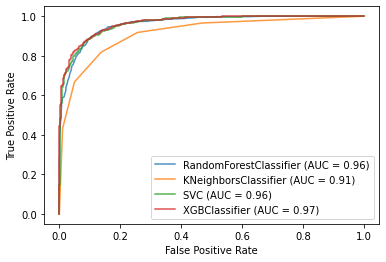

In [83]:
#roc plot
ax = plt.gca()
rfc_disp.plot(ax=ax, alpha=0.8)
knn_disp.plot(ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
xgb_disp.plot(ax=ax, alpha=0.8)
plt.show()

We can see that XGBoost, SVC and Random forest gave us almost the same result.
Let's check now what factors were the most important ones:

<AxesSubplot:xlabel='Feature'>

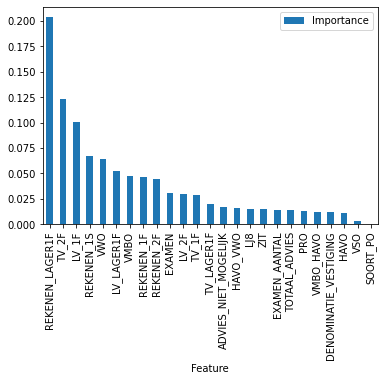

In [84]:
importances = pd.DataFrame({
    'Feature': data.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False).set_index('Feature')
importances.plot.bar()

It looks like the most important factors are: the amount of students who don't have enough math skills and the amount of students who have good language skills.

### Conclusion

As a result I can say that XGBoost gives the best result for the CET exam level prediction.

Also when I choose a school with a better then average quality of education, I need to take a look at the number of student who know math not so well (and probably the smaller the amount of such students is, the better the average CET score a school would have).